In [1]:
# %pip install braindecode mne umap-learn skorch==0.10.0
# %pip install umap-learn[plot] pandas matplotlib datashader bokeh holoviews scikit-image colorcet

# imports
import os
import importlib
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import mne
import torch
from torch import nn
from torch.utils.data import DataLoader
from braindecode.datasets.sleep_physionet import SleepPhysionet
from braindecode.datasets import BaseConcatDataset
from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.preprocessing.windowers import create_windows_from_events
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode import EEGClassifier
from braindecode.datautil.preprocess import zscore
from braindecode.samplers.ssl import RelativePositioningSampler
from braindecode.datasets import (create_from_mne_raw, create_from_mne_epochs)

from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, EarlyStopping, EpochScoring
from skorch.utils import to_tensor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# visualizations

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import learning_curve
from matplotlib import cm
import umap.umap_ as umap
import umap.plot

from umap import UMAP
import plotly.express as px

# ----


# classes
from helper_funcs import HelperFuncs as hf
from ContrastiveNet import *
from RelativePositioningDataset import *
from plot import Plot

from tqdm import tqdm

# Authors: Hubert Banville <hubert.jbanville@gmail.com>
#
# License: BSD (3-clause)


random_state = 87
n_jobs = 1
batch_size = 256
sfreq = 100
n_epochs = 25
n_classes = 5
cv = 5
n_epochs = 5
lr = 5e-3

/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/braindecode/datautil/preprocess.py:10: UserWarning: datautil.preprocess module is deprecated and is now under preprocessing.preprocess, please use from import braindecode.preprocessing.preprocess
  warn('datautil.preprocess module is deprecated and is now under '


Loading data, preprocessing, and windowing

In [2]:
dataset = SleepPhysionet(
    subject_ids=[*range(5)],
    recording_ids=[1],
    crop_wake_mins=30,
    load_eeg_only=True,
    sfreq=sfreq
)

high_cut_hz = 30

preprocessors = [
    Preprocessor(lambda x: x * 1e6), # convert to microvolts
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs) # high pass filtering
]

# Transform the data
preprocess(dataset, preprocessors)

# change to 5 second windows
window_size_s = 5
sfreq = 100
# window_size_samples = window_size_s * sfreq
window_size_samples = 500

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

windows_dataset = create_windows_from_events(
    dataset, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples, preload=True, mapping=mapping)

preprocess(windows_dataset, [Preprocessor(zscore)])

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2508000  =      0.000 ... 25080.000 sec

/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/braindecode/preprocessing/preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3060000  =      0.000 

/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function zscore is deprecated; will be removed in 0.7.0. Use sklearn.preprocessing.scale instead.
  warnings.warn(msg, category=FutureWarning)


In [183]:
subjects = np.unique(windows_dataset.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)


split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
         if ds.description['subject'] in values])


# obtain X and y data from datasets
# nn_set, loader = dict(), dict()
# for name, split in splitted.items():
#     _set = []
#     split.return_pair = False
#     for ds in split.datasets:
#         for window in ds:
#             _set += [window[0:2]]
            
#     nn_set[name] = _set
#     loader[name] = DataLoader(nn_set[name], batch_size=1, num_workers=1, shuffle=True)

# dataiter = iter(loader['train'])
# train_data, labels = dataiter.next()

In [184]:
num_workers = 1
batch_size = 256
desc = None

# fetch pretrained model
ssl_model = torch.load("models/pretrained/2021_12_16__10_23_49_sleep_staging_5s_windows_83_subjects_cpu_15_epochs_100hz.model")

# Extract features with the trained embedder
dataset = []
data, raw_data, descriptions = dict(), dict(), dict()
for name, split in splitted.items():
    split.return_pair = False  # Return single windows
    loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    with torch.no_grad():
        feats = [ssl_model.emb(batch_x.to(device)).cpu().numpy() for batch_x, _, _ in loader]
        # make a copy of the vectors WITHOUT passing them through the pretrained model
        raw_vectors = [batch_x.to(device).cpu().numpy() for batch_x, _, _ in loader]
    # descriptions values according to dataset in use: CHANGE MANUALLY
    if desc is not None:
        descriptions[name] = split.get_metadata()[desc].values  
    data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)
    # concatenate channels per window such that you will have 10s windows
    raw_data[name] = ([np.concatenate(x.T) for x in np.concatenate(raw_vectors)], split.get_metadata()['target'].values)
    # add data and targets to [dataset]
    for ds in split.datasets:
        for window in ds:
            dataset += [window[0:2]]

# combine all vectors (X) and labels (y) from DATA sets
X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])
if desc is not None:
    desc = np.concatenate([v for k, v in descriptions.items()])

In [185]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to reproduce results
set_random_seeds(seed=random_state, cuda=device == 'cuda')

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_dataset[0][0].shape
emb_size = sfreq

fs_model = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_classes=n_classes,
    n_conv_chs=16,
    input_size_s=input_size_samples / sfreq,
    dropout=0,
    apply_batch_norm=True
)

In [186]:
fs_model

SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=96, out_features=5, bias=True)
  )
)

In [188]:
import torch.optim as optim
from sklearn.model_selection import KFold

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fs_model.parameters(), lr=lr, momentum=0.9)

# 5-fold cross-validation
kfold = KFold(n_splits=cv, shuffle=True, random_state=42)

In [187]:
def reset_weights(m):
	'''
		Try resetting model weights to avoid
		weight leakage.
	'''
	for layer in m.children():
		if hasattr(layer, 'reset_parameters'):
			# print(f'Reset trainable parameters of layer = {layer}')
			layer.reset_parameters()

# confusion matrix
def conf_matrix_class_report(model, dataloader, n_classes):
		confusion_matrix = torch.zeros(n_classes, n_classes)
		y_pred = []
		y_true = []
		with torch.no_grad():
			for i, (inputs, labels) in enumerate(dataloader):
				inputs = inputs.to(device)
				labels = labels.to(device)
				outputs = model(inputs)
				_, preds = torch.max(outputs, 1)
				for t, p in zip(labels.view(-1), preds.view(-1)):
								confusion_matrix[t, p] += 1
				y_pred += [preds]
				y_true += [labels]

		y_pred = np.concatenate(y_pred)
		y_true = np.concatenate(y_true)

		class_report = classification_report(y_true=y_true, y_pred=y_pred)

		torch.set_printoptions(sci_mode=False)
		return confusion_matrix, class_report

In [ ]:
results = {}

# 5-fold cross-validation
kfold = KFold(n_splits=2, shuffle=True, random_state=42)

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
	# Print
	print(f'FOLD {fold}')
	print('--------------------------------')
	
	# Sample elements randomly from a given list of ids, no replacement.
	train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
	test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
	
	# Define data loaders for training and testing data in this fold
	trainloader = DataLoader(dataset, batch_size=5, sampler=train_subsampler)
	testloader = DataLoader(dataset, batch_size=5, sampler=test_subsampler)

	# Init the neural network
	print('Resetting trainable parameters...')
	fs_model.apply(reset_weights)
	
	# Run the training loop for defined number of epochs
	for epoch in range(3):
		print(f'Epoch {epoch+1}')
		# Set current loss value
		running_loss = 0.0

		# Iterate over the DataLoader for training data
		for i, data in enumerate(tqdm(trainloader, 0)):
			# Get inputs
			inputs, targets = data
			
			# Zero the gradients
			optimizer.zero_grad()
			
			# Perform forward pass
			outputs = fs_model(inputs)
			# Compute loss
			loss = criterion(outputs, targets)
			# Perform backward pass
			loss.backward()
			# Perform optimization
			optimizer.step()
			
			# Print statistics
			running_loss += loss.item()
			# if i % 25 == 24:
		print('Loss after mini-batch %5d: %.3f' % (i + 1, running_loss))
		running_loss = 0.0
					
	# Process is complete.
	print('Training process has finished. Saving trained model.')

	# Print about testing
	print('Starting testing')
	
	# Saving the model
	save_path = f'./model-fold-{fold}.pth'
	torch.save(fs_model.state_dict(), save_path)

	# Evaluation for this fold
	correct, total = 0, 0
	with torch.no_grad():
		# Iterate over the test data and generate predictions
		for i, data in enumerate(testloader, 0):

			# Get inputs
			inputs, targets = data

			# Generate outputs
			outputs = fs_model(inputs)

			# Set total and correct
			_, predicted = torch.max(outputs.data, 1)
			total += targets.size(0)
			correct += (predicted == targets).sum().item()

		bal_acc = balanced_accuracy_score(y_pred=predicted, y_true=targets)

		# Print accuracy
      	# print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
		print(f'Balanced Accuracy for fold {bal_acc}')
		print('--------------------------------')
		results[fold] = bal_acc
	break

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {cv} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
	print(f'Fold {key}: {value} %')
	sum += value
print(f'Average: {sum/len(results.items())} %')

In [ ]:
matrix, report = conf_matrix_class_report(fs_model, loader['test'], n_classes)
print(matrix)
print(report)

In [261]:
input, label = next(iter(loader['test']))
output = fs_model(input)

In [ ]:
labels = []
for x in loader['train']:
    labels += [x[-1]]
np.unique(labels)

In [ ]:
space = np.linspace(0.01,1,5)

# 5-fold cross-validation
kfold = KFold(n_splits=2, shuffle=True, random_state=42)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    train_space = np.round(space * len(train_ids))
    # print(train_space)

    for i, training_set in enumerate(train_space):
        _set = train_ids[:int(training_set)]
        # print(f'#{i} {_set} | {len(_set)}')
        


In [254]:
space = np.linspace(0.01,1,10)
fs_results = []
train_sizes = []
batch_size = 5
cv = 5
n_epochs = 15

# 5-fold cross-validation
kfold = KFold(n_splits=cv, shuffle=True, random_state=42)

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    print(f'FOLD {fold}')
    line = '-'*120
    print(line)

    train_space = np.round(space * len(train_ids))
    # test_space = np.round(space * len(test_ids))
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids) # all testing examples
    # print(train_space)
    set_bal_acc = []

    for i, training_set in enumerate(train_space):
        _set = train_ids[:int(training_set)]
        print(f'#{i}[{len(_set)}] \t -- epochs ', end='')
        
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(_set)
        # Define data loaders for training and testing data in this fold
        trainloader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        testloader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

        for epoch in range(n_epochs):
            running_loss = 0.0
            bal_acc = []
            print(f' | {epoch}', end='')

            # Iterate over the DataLoader for training data
            for _i, data in enumerate(trainloader, 0):

                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = fs_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

        # TESTING all test space
        y_true = []
        y_pred = []
        total = 0
        with torch.no_grad():
            for _i, data in enumerate(testloader):
                inputs, labels = data
                outputs = fs_model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                y_true += [labels]
                y_pred += [predicted]
                total += labels.size(0)
                # correct += (predicted == labels).sum().item()

            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)
        _bal_acc = balanced_accuracy_score(y_true, y_pred)
        set_bal_acc += [_bal_acc]
        print(f' --> bal_acc: {_bal_acc:.4f}')
        running_loss = 0.0

    fs_results += [set_bal_acc]

print('Finished Training')

fs_results = np.array(fs_results.T)

FOLD 0
------------------------------------------------------------------------------------------------------------------------
#0[246] 	 -- epochs  | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8

KeyboardInterrupt: 

In [245]:
# results = np.array(results).T
train_space.shape

(5,)

In [173]:
# from copy import deepcopy
# copy_fold_bal_acc = deepcopy(fold_bal_acc)

In [176]:
matrix, report = conf_matrix_class_report(fs_model, testloader, n_classes)
print(matrix)
print(report)

tensor([[     1315.,       109.,        41.,         3.,        77.],
        [       98.,       440.,       206.,         5.,       165.],
        [       20.,       111.,      4345.,       323.,       192.],
        [        1.,         1.,       204.,       910.,         2.],
        [       28.,       161.,       232.,         1.,      1265.]])
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1545
           1       0.54      0.48      0.51       914
           2       0.86      0.87      0.87      4991
           3       0.73      0.81      0.77      1118
           4       0.74      0.75      0.75      1687

    accuracy                           0.81     10255
   macro avg       0.76      0.75      0.75     10255
weighted avg       0.81      0.81      0.81     10255



In [120]:
outputs = fs_model(inputs)
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([2.2961, 4.9992, 4.9605, 6.7471]),
indices=tensor([1, 4, 4, 2]))

In [37]:
example = next(iter(loader['test']))
inputs, labels = example
outputs = fs_model(inputs)
outputs

tensor([[-2.6006, -2.1025, -0.4791, -4.0898, -0.2418]],
       grad_fn=<AddmmBackward>)

In [243]:
np.array(fold_bal_acc).shape

(45, 61545, 3)

In [154]:
[len(x) for x in results], len(train_sizes)

([19, 19, 19, 19, 19], 19)

In [181]:
results[0]

array([[0.73696631, 0.71454731, 0.73481457],
       [0.73696631, 0.71454731, 0.73481457],
       [0.73696631, 0.71454731, 0.73481457],
       ...,
       [0.67572514, 0.7183993 , 0.68217892],
       [0.67572514, 0.7183993 , 0.68217892],
       [0.67572514, 0.7183993 , 0.68217892]])

:: plotting learning curves... 

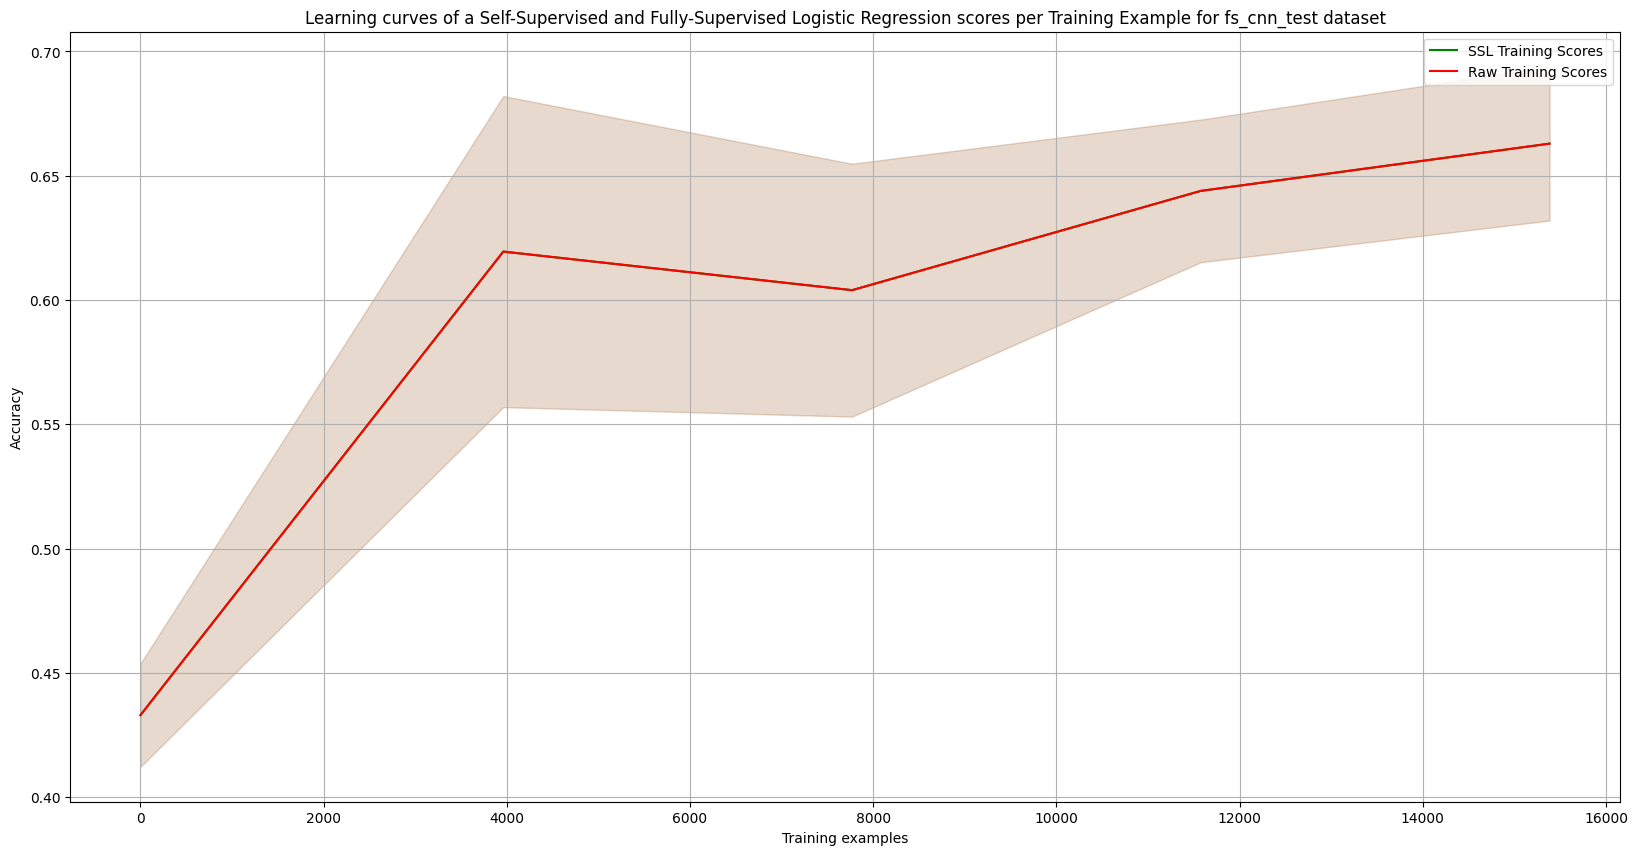

Done


In [248]:
from plot import Plot
p = Plot('test', 'test_string', save=False, show=True)

p.plot_learning_curves(train_space[1:], train_space[1:], results, results, 'fs_cnn_test')

In [171]:
# Train pretrained features

ssl_model = nn.Sequential(
    nn.Conv2d(100,30,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(30,10,kernel_size=2,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    # nn.Flatten(),
    # nn.Linear(256*4*4,1024),
    nn.Softmax(1),
    nn.Linear(10,n_classes)
)
ssl_model


Sequential(
  (0): Conv2d(100, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(30, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Softmax(dim=1)
  (7): Linear(in_features=10, out_features=5, bias=True)
)

In [ ]:
train = DataLoader(X[0], 5, shuffle=True)


In [172]:
ssl_model(X[0])

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


### TESTING

In [180]:
correct = 0
total = 0
y_true = []
y_pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(loader['test']):
        inputs, labels = data
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y_true += [labels]
        y_pred += [predicted]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# print(f'#\t pred\t true')
# for i in range(len(y_pred)):
#     print(f"{i}\t {y_pred[i]}\t {labels[i]}")

print(f"Accuracy of the network on the {len(nn_set['test'])} test data: {100 * correct // total} %")

Accuracy of the network on the 5017 test data: 13 %


In [147]:
# save model
PATH = './sleep-fs.model'
torch.save(fs_model.state_dict(), PATH)

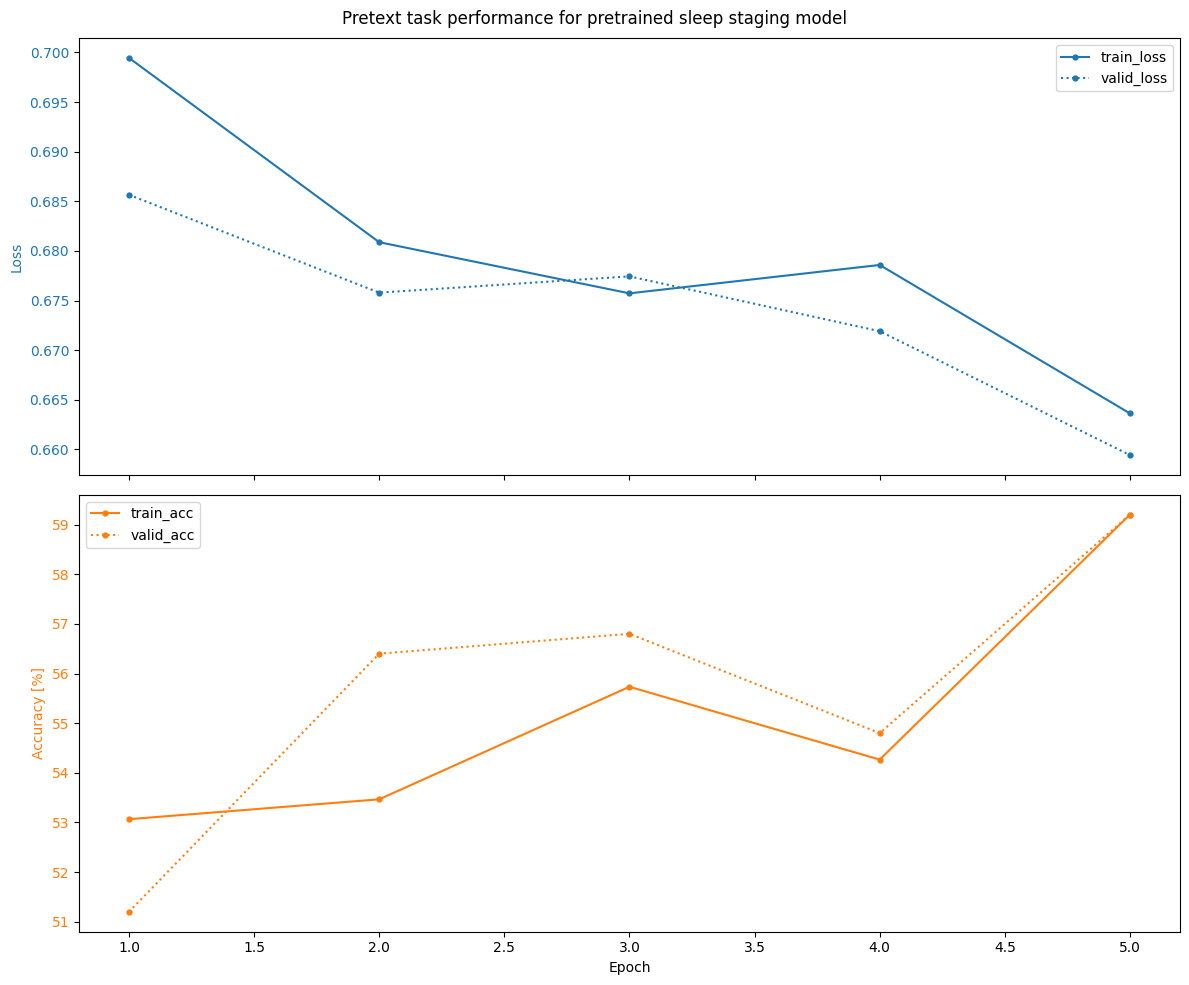

In [11]:
# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']


fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax[0].plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    lines1, labels1 = ax[0].get_legend_handles_labels()

    ax[0].tick_params(axis='y', labelcolor='tab:blue')
    ax[0].set_ylabel('Loss', color='tab:blue')
    ax[0].legend(lines1, labels1)

for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax[1].grid()
    ax[1].plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

    lines2, labels2 = ax[1].get_legend_handles_labels()

    ax[1].tick_params(axis='y', labelcolor='tab:orange')
    ax[1].set_ylabel('Accuracy [%]', color='tab:orange')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(lines2, labels2)


plt.suptitle('Pretext task performance for pretrained sleep staging model')
plt.tight_layout()
plt.style.use('seaborn-talk')
plt.rc('font', size=16)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.savefig('sample_pretrain.pdf', format='pdf')
plt.show()
